In [4]:
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import random
from torch import tensor
sns.set()

In [11]:
class ResultsAnalysis:
    
    def __init__(self, yaml_path, noise_level = None, res_level = None):
        
        self.class_names = ('Disturbed Galaxies', 'Merging Galaxies', 
        'Round Smooth Galaxies', 'In-between Round Smooth Galaxies', 
        'Cigar Shaped Smooth Galaxies', 'Barred Spiral Galaxies', 
        'Unbarred Tight Spiral Galaxies', 'Unbarred Loose Spiral Galaxies', 
        'Edge-on Galaxies without Bulge', 'Edge-on Galaxies with Bulge')
    
        self.noise_level = noise_level
        self.res_level = res_level
        with open(yaml_path, "r") as f:
            data = yaml.safe_load(f)
            
        models = []
        accuracies = []
        for model_name, model_data in data.items():
            # Create a dictionary to store the data for each class
            class_data = {}

            for class_name, class_metrics in model_data.items():
                    # Add the metrics for the class to the dictionary
                    if isinstance(class_metrics, dict):
                        class_data[class_name] = {
                            "f1-score": class_metrics["f1-score"],
                            "precision": class_metrics["precision"],
                            "recall": class_metrics["recall"],
                            "support": class_metrics["support"]
                        }
                    else:
                        accuracies.append(class_metrics)
                        
            models.append({
                "Model": model_name,
                **{f"{class_name.lower()} - {metric_name}": class_metrics[metric_name] for class_name, class_metrics in class_data.items() for metric_name in class_metrics}
            })

        # Create a pandas dataframe from the list of dictionaries
        self.df = pd.DataFrame(models)
        self.df['Accuracy'] = accuracies
        
    def plot_heatmap(self, ax=None):
        
        self.df_filtered = self.df[self.df.index != "Accuracy"].drop(columns=['Accuracy'])
        self.df_filtered = self.df_filtered.set_index("Model")
        self.df_filtered = self.df_filtered.drop(columns=[col for col in self.df_filtered.columns if 'support' in col])
        self.df_filtered = self.df_filtered.drop(columns=[col for col in self.df_filtered.columns if 'precision' in col])
        self.df_filtered = self.df_filtered.drop(columns=[col for col in self.df_filtered.columns if 'recall' in col])
        # self.df_filtered = self.df_filtered.drop(columns=['weighted avg - f1-score'])

        # Transpose the dataframe so that models are on the x-axis and classes are on the y-axis
        self.df_transposed = self.df_filtered.transpose()
        
        # Set the size of the plot
        if ax is None:
            fig, ax = plt.subplots()

        # Create the heatmap
        sns.heatmap(self.df_transposed, annot=False, cmap="Blues", ax=ax, cbar_kws={'label': ''})

        # Set the title and axis labels
        if self.noise_level is not None:
            ax.set_title(f"F1 Scores (Noise Level: {self.noise_level}%)")
            
        if self.res_level is not None:
            ax.set_title(f"F1 Scores (Resolution Scaling: {self.res_level}%)")
       
        self.labels = [label.get_text().replace("f1-score", "") for label in ax.get_yticklabels()]
        ax.set_yticklabels(self.labels)
        ax.tick_params(axis='x', rotation=45)     
        ax.set_xlabel("Model")

        
    def plot_accuracy(self, ax=None):
        model_names = self.df["Model"].tolist()
        accuracies = self.df['Accuracy'].tolist()

        # Sort the model names and accuracy values in descending order of accuracy
        model_names, accuracies = zip(*sorted(zip(model_names, accuracies), key=lambda x: x[1], reverse=True))

        # Set the size of the plot
        if ax is None:
            fig, ax = plt.subplots()

        # Create a horizontal bar chart showing the accuracy for each model
        bars = ax.barh(model_names, accuracies)

        # Set the color of the bars to indicate the accuracy, with red for the worst performing model and green for the best performing model
        for i, bar in enumerate(bars):
            if i == 0:
                bar.set_color("g")
            elif i == len(bars) - 1:
                bar.set_color("r")
            else:
                bar.set_color("gray")

        # Add labels and a title to the chart
        ax.set_xlabel("Accuracy")
        ax.set_xticks(np.arange(0, 1.1, 0.1))
        if self.noise_level is not None:
            ax.set_title(f"F1 Scores (Noise Level: {self.noise_level}%)")
            
        elif self.res_level is not None:
            ax.set_title(f"F1 Scores (Resolution Scaling: {self.res_level}%)")
            
    def plot_precision_recall(self, class_name: str):
        class_name = class_name.lower()
        models = self.df['Model'].unique()
        models_list = ', '.join(models).split(', ')
        colors = plt.cm.tab20(np.arange(20))

        additional_colors = np.random.rand(5, 3)
        if additional_colors.shape[1] < colors.shape[1]:
            additional_colors = np.hstack([additional_colors, np.ones((5, colors.shape[1] - additional_colors.shape[1]))])
        colors = np.vstack([colors, additional_colors])

        precision_col = [col for col in self.df.columns if 'precision' in col.lower() and class_name in col.lower()][0]
        recall_col = [col for col in self.df.columns if 'recall' in col.lower() and class_name in col.lower()][0]

        for i, model_name in enumerate(models_list):
            model_data = self.df[self.df['Model'] == model_name]
            plt.scatter(model_data[recall_col], model_data[precision_col], label=model_name, color=colors[i])

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'{class_name.title()} Precision-Recall Scatter Plot (Noise Level: {self.noise_level}%)')
        plt.legend(bbox_to_anchor=(1.05, 1.05))
        plt.show()
        


In [24]:
data = ResultsAnalysis('/Users/snehpandya/Projects/GCNNMorphology/data/new_icml/new_results/test_data_imbalanced.yaml',0)
snr_25 = ResultsAnalysis('/Users/snehpandya/Projects/GCNNMorphology/data/new_icml/new_results/snr_25.yaml', noise_level=75)
snr_50 = ResultsAnalysis('/Users/snehpandya/Projects/GCNNMorphology/data/new_icml/new_results/snr_50.yaml', noise_level=50)
snr_75 = ResultsAnalysis('/Users/snehpandya/Projects/GCNNMorphology/data/new_icml/new_results/snr_75.yaml', noise_level=25)
res_25 = ResultsAnalysis('/Users/snehpandya/Projects/GCNNMorphology/data/new_icml/new_results/res_25.yaml', res_level=25)
res_50 = ResultsAnalysis('/Users/snehpandya/Projects/GCNNMorphology/data/new_icml/new_results/res_50.yaml', res_level=50)
res_75 = ResultsAnalysis('/Users/snehpandya/Projects/GCNNMorphology/data/new_icml/new_results/res_75.yaml', res_level=75)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


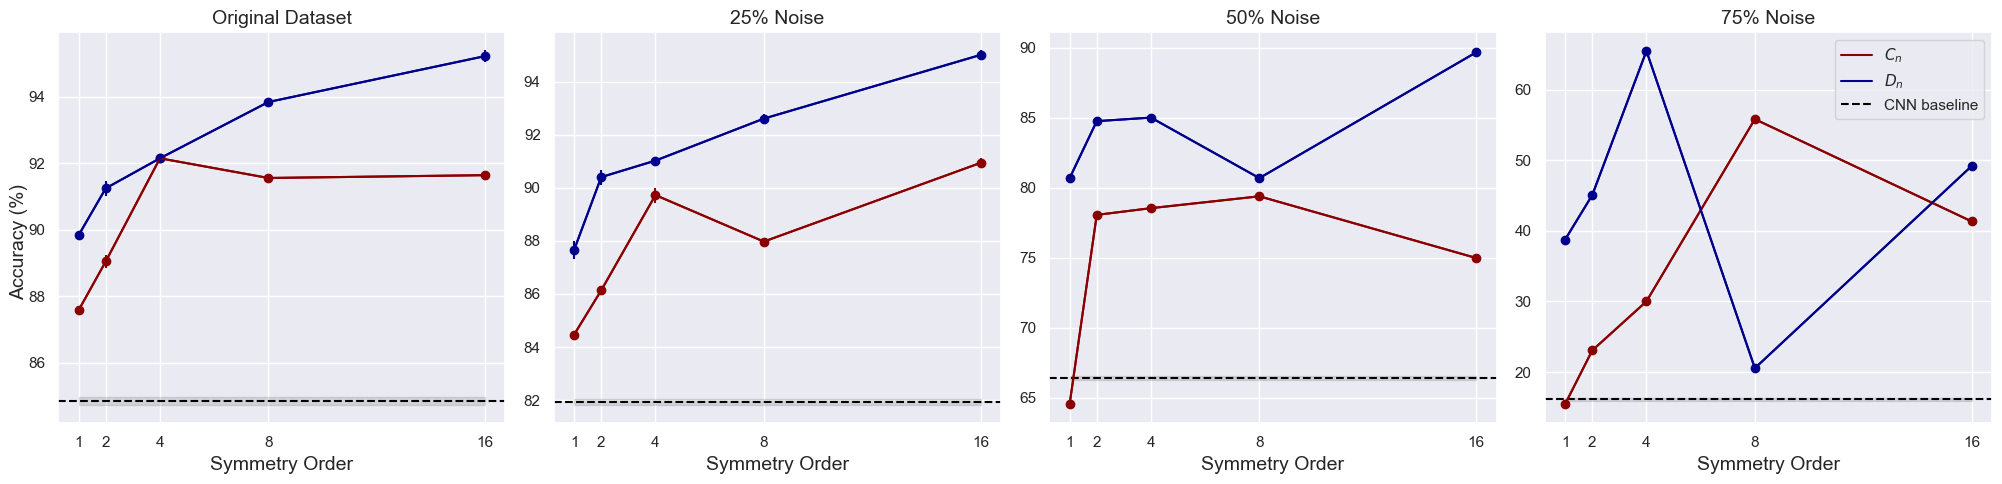

In [25]:
import matplotlib.pyplot as plt

data_frames = [data, snr_75, snr_50, snr_25] # Replace these with your actual data frames

N_vals = [1, 2, 4, 8, 16]

fig, axes = plt.subplots(1, 4, figsize=(20, 5)) # Create 1 row of 4 subplots
titles = ['Original Dataset', '25% Noise', '50% Noise', '75% Noise']
CNN_val = data.df[data.df['Model'] == 'CNN']['Accuracy'].tolist()[0]

for idx, data in enumerate(data_frames):
    C_accuracies = [data.df[data.df['Model'] == f'C{N}']['Accuracy'].values.item() for N in N_vals]
    D_accuracies = [data.df[data.df['Model'] == f'D{N}']['Accuracy'].values.item() for N in N_vals]
    ## convert accuracies to percentages
    C_accuracies = [x * 100 for x in C_accuracies]
    D_accuracies = [x * 100 for x in D_accuracies]
    C_accuracy_errors_og = [0.11, 0.19, 0.08, 0.07, 0.09]
    D_accuracy_errors_og = [0.13, 0.22, 0.12, 0.09, 0.18]
    C_accuracy_errors_25 = [0.11, 0.12, 0.28, 0.15, 0.20]
    D_accuracy_errors_25 = [0.33, 0.28, 0.13, 0.16, 0.18]
    C_accuracy_errors_50 = [0.11, 0.18, 0.11, 0.12, 0.30]
    D_accuracy_errors_50 = [0.21, 0.10, 0.15, 0.09, 0.16]
    C_accuracy_errors_75 = [0.20, 0.07, 0.14, 0.20, 0.10]
    D_accuracy_errors_75 = [0.14, 0.11, 0.12, 0.06, 0.09]
    C_accuracy_errors_list = [C_accuracy_errors_og, C_accuracy_errors_25, C_accuracy_errors_50, C_accuracy_errors_75]
    D_accuracy_errors_list = [D_accuracy_errors_og, D_accuracy_errors_25, D_accuracy_errors_50, D_accuracy_errors_75]
    CNN_errors = [0.13, 0.13, 0.13, 0.17]

    axes[idx].plot(N_vals, C_accuracies, label='$C_n$', color='darkred')
    axes[idx].plot(N_vals, D_accuracies, label='$D_n$', color='darkblue')
    axes[idx].scatter(N_vals, C_accuracies, color='darkred')
    axes[idx].scatter(N_vals, D_accuracies, color='darkblue')
    axes[idx].errorbar(N_vals, C_accuracies, yerr=C_accuracy_errors_list[idx], color='darkred')
    axes[idx].errorbar(N_vals, D_accuracies, yerr=D_accuracy_errors_list[idx], color='darkblue')

    CNN_val = 100*data.df[data.df['Model'] == 'CNN']['Accuracy'].tolist()[0]
    axes[idx].axhline(CNN_val, label='CNN baseline', color='black', ls='--')
    axes[idx].fill_between(N_vals, (CNN_val - CNN_errors[idx]), (CNN_val + CNN_errors[idx]), color='black', alpha=0.1)
    axes[-1].legend()
    axes[idx].set_xticks(N_vals)
    axes[idx].set_xlabel('Symmetry Order', fontsize=14)
    if idx > 0:
        axes[idx].set_ylabel('')

    axes[idx].set_title(titles[idx], fontsize=14)

plt.tight_layout()
fig.text(0.0, 0.5, 'Accuracy (%)', va='center', rotation='vertical', fontsize=14)
plt.savefig('../../plots/accuracies_neurips.png', bbox_inches='tight', dpi=300)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


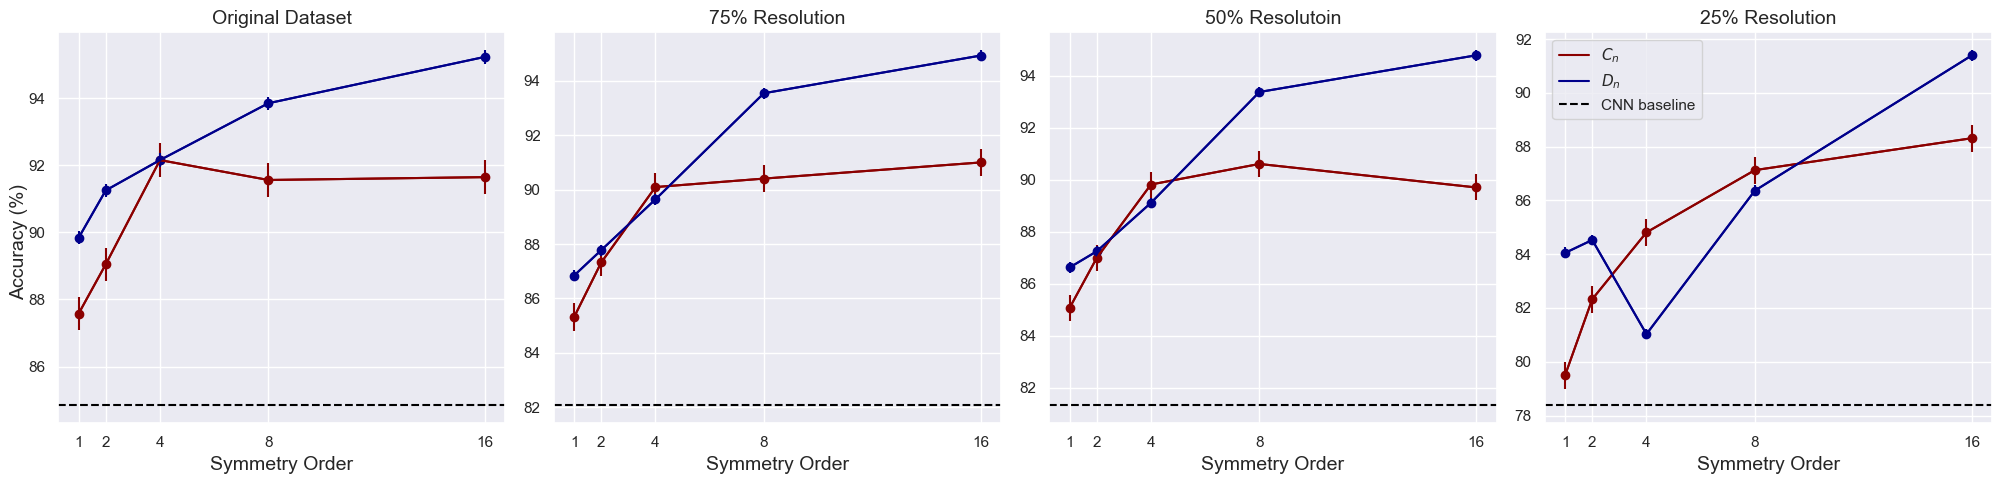

In [109]:
import matplotlib.pyplot as plt

data_frames = [data, res_75, res_50, res_25] # Replace these with your actual data frames

N_vals = [1, 2, 4, 8, 16]

fig, axes = plt.subplots(1, 4, figsize=(20, 5)) # Create 1 row of 4 subplots
titles = ['Original Dataset', '75% Resolution', '50% Resolutoin', '25% Resolution']

for idx, data in enumerate(data_frames):
    C_accuracies = [data.df[data.df['Model'] == f'C{N}']['Accuracy'].values.item() for N in N_vals]
    D_accuracies = [data.df[data.df['Model'] == f'D{N}']['Accuracy'].values.item() for N in N_vals]
    ## convert accuracies to percentages
    C_accuracies = [x * 100 for x in C_accuracies]
    D_accuracies = [x * 100 for x in D_accuracies]
    C_accuracy_errors = [.5] * len(N_vals)
    D_accuracy_errors = [.2] * len(N_vals)

    axes[idx].plot(N_vals, C_accuracies, label='$C_n$', color='darkred')
    axes[idx].plot(N_vals, D_accuracies, label='$D_n$', color='darkblue')
    axes[idx].scatter(N_vals, C_accuracies, color='darkred')
    axes[idx].scatter(N_vals, D_accuracies, color='darkblue')
    axes[idx].errorbar(N_vals, C_accuracies, yerr=C_accuracy_errors, color='darkred')
    axes[idx].errorbar(N_vals, D_accuracies, yerr=D_accuracy_errors, color='darkblue')

    axes[idx].axhline(100*data.df[data.df['Model'] == 'CNN']['Accuracy'].tolist()[0], label='CNN baseline', color='black', ls='--')
    axes[-1].legend()
    axes[idx].set_xticks(N_vals)
    axes[idx].set_xlabel('Symmetry Order', fontsize=14)
    if idx > 0:
        axes[idx].set_ylabel('')

    axes[idx].set_title(titles[idx], fontsize=14)

plt.tight_layout()
fig.text(0.0, 0.5, 'Accuracy (%)', va='center', rotation='vertical', fontsize=14)
plt.savefig('../../plots/accuracies_2_neurips.png', bbox_inches='tight', dpi=300)
plt.show()

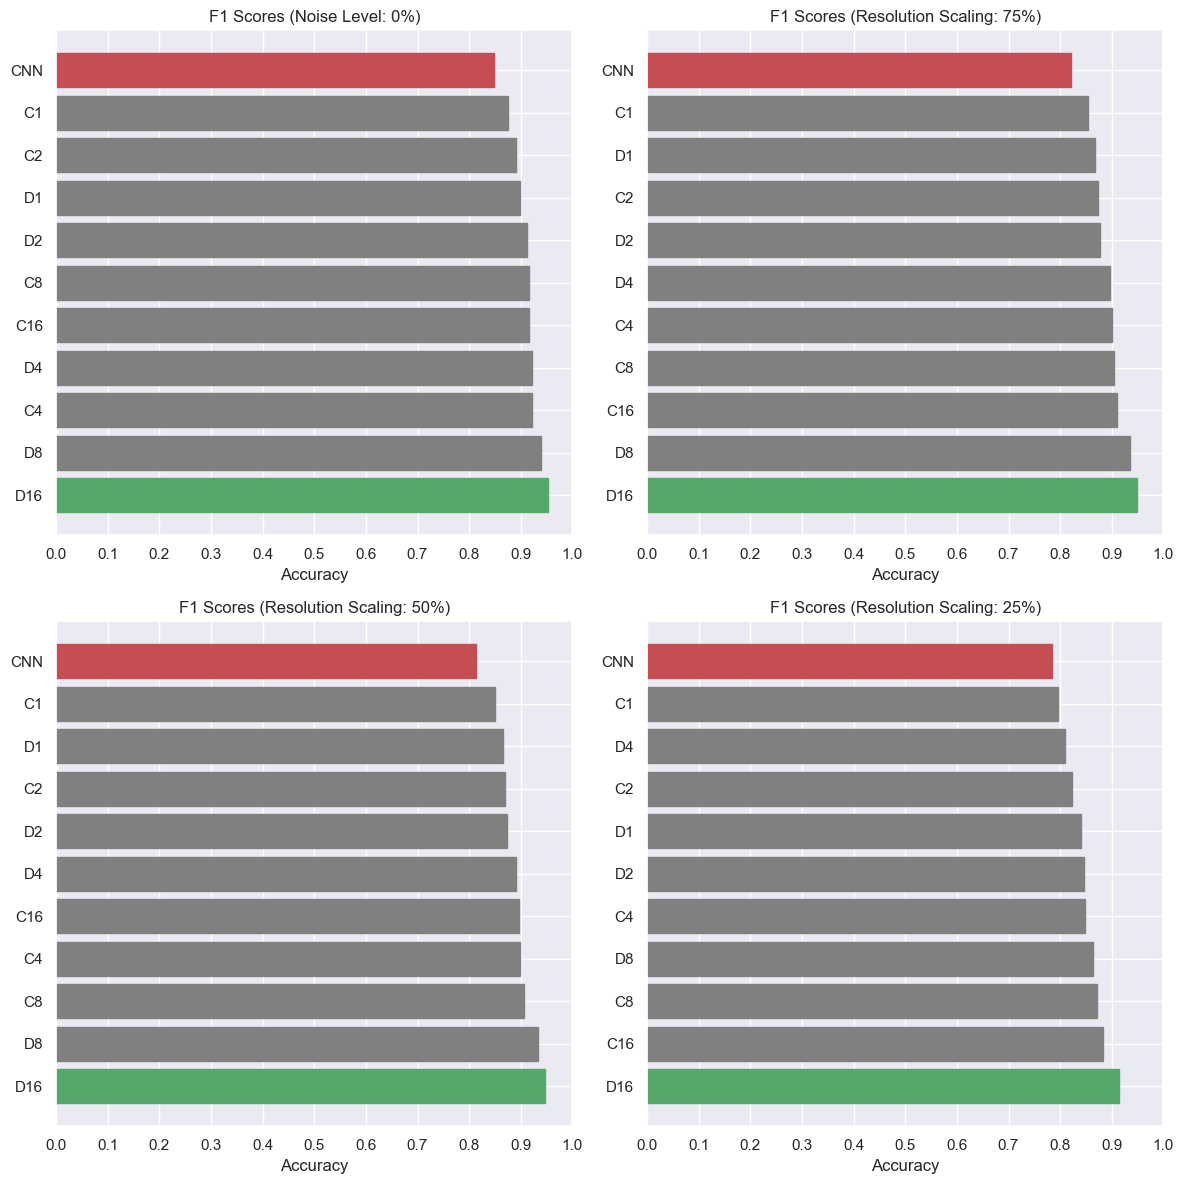

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
data.plot_accuracy(ax=axs[0, 0])
res_75.plot_accuracy(ax=axs[0,1])
res_50.plot_accuracy(ax=axs[1,0])
res_25.plot_accuracy(ax=axs[1,1])
fig.tight_layout()

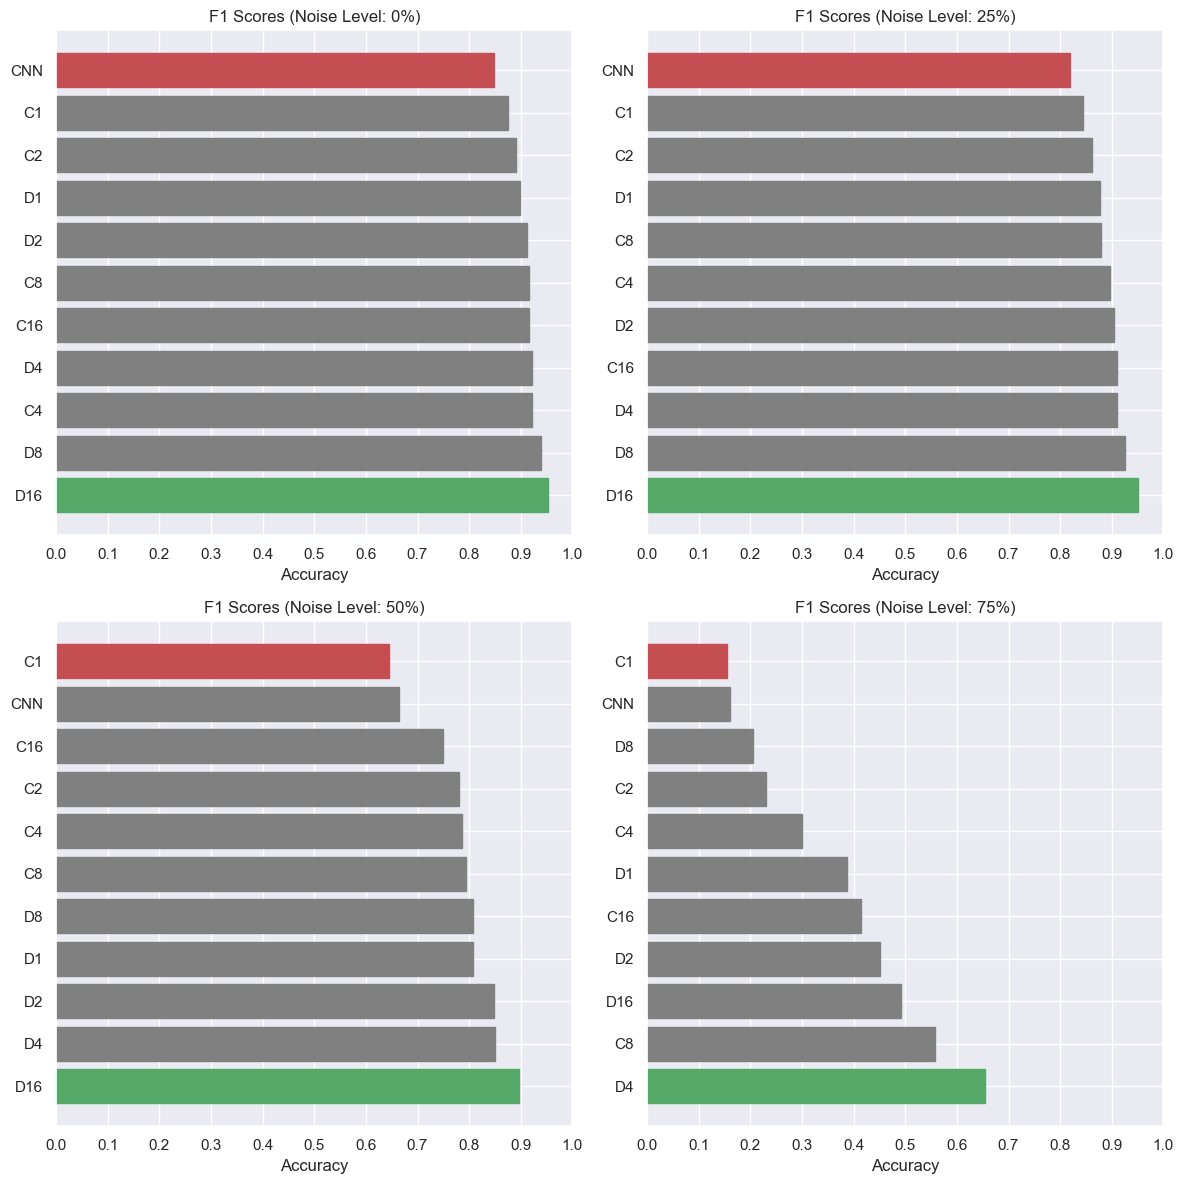

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
data.plot_accuracy(ax=axs[0, 0])
snr_75.plot_accuracy(ax=axs[0,1])
snr_50.plot_accuracy(ax=axs[1,0])
snr_25.plot_accuracy(ax=axs[1,1])
fig.tight_layout()

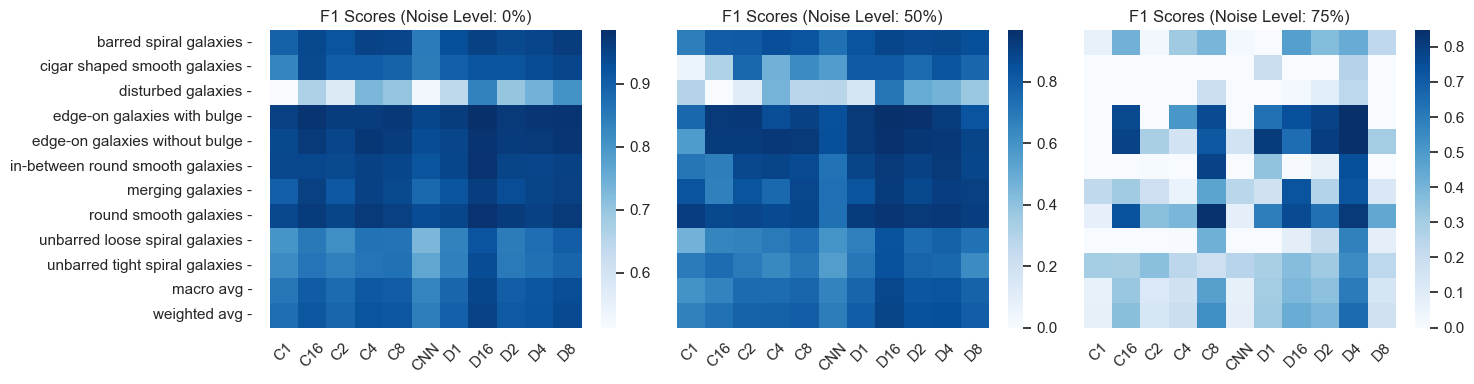

In [44]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

data.plot_heatmap(ax=ax1)
ax1.set_xlabel('')
snr_50.plot_heatmap(ax=ax2)
ax2.set_yticklabels([])
ax2.set_xlabel('')

snr_25.plot_heatmap(ax=ax3)
ax3.set_yticklabels([])
ax3.set_xlabel('')
fig.tight_layout()
fig.savefig('../../plots/f1_scores_neurips.png', bbox_inches='tight', dpi=300)

In [1]:
import h5py

In [12]:
filename = "/Users/snehpandya/Projects/GCNNMorphology/data/test_data_50.hdf5"

with h5py.File(filename, "r") as f:

    print("Keys: %s" % f.keys())
    a_group_key = list(f.keys())[0]
    data = list(f[a_group_key])
    data = list(f[a_group_key])
    # preferred methods to get dataset values:
    ds_obj = f[a_group_key]      # returns as a h5py dataset object
    ds_arr = f[a_group_key][()]  # returns as a numpy array
    z = f['redshifts'][()]
    label = f['labels'][()]
    images = f['images'][()]

Keys: <KeysViewHDF5 ['angles', 'images', 'labels', 'redshifts']>


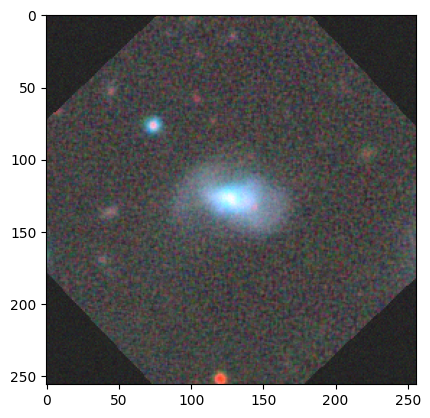

In [13]:
import matplotlib.pyplot as plt
plt.imshow(images[10])

In [7]:
filename = "/Users/snehpandya/Projects/GCNNMorphology/data/test_data.hdf5"

with h5py.File(filename, "r") as f:

    print("Keys: %s" % f.keys())
    a_group_key = list(f.keys())[0]
    data = list(f[a_group_key])
    data = list(f[a_group_key])
    # preferred methods to get dataset values:
    ds_obj = f[a_group_key]      # returns as a h5py dataset object
    ds_arr = f[a_group_key][()]  # returns as a numpy array
    z = f['redshifts'][()]
    label = f['labels'][()]
    images = f['images'][()]

Keys: <KeysViewHDF5 ['angles', 'images', 'labels', 'redshifts']>
